In [1]:
!nvidia-smi # Checking GPU

Thu Jan 16 18:26:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:B7:00.0 Off |                    0 |
| N/A   38C    P0             73W /  400W |   32892MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
!pip install datasets
!pip install evaluate
!pip install rouge-score
!pip install py7zr 
!pip install evaluate
!pip install textblob
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install datasets transformers[sentencepiece]
!pip install sentencepiece
!pip install accelerate==0.26.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 727.2 kB/s eta 0:00:00a 0:00:01
INFO: pip is looking at multiple versions of huggingface-hub to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of huggingface-hub to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
from datasets import Dataset,load_dataset
import shutil
from IPython.display import display
import nltk
from scipy.stats import shapiro, skew, anderson, kstest, gaussian_kde,spearmanr
import math

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Transformers
from transformers import BartTokenizer, BartForConditionalGeneration      # BERT Tokenizer and architecture
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments         
from transformers import pipeline                                         # Pipeline
from transformers import DataCollatorForSeq2Seq                           # DataCollator to batch the data 
import torch                                                              
                                                         


# Other NLP libraries
from textblob import TextBlob                                             
from sklearn.feature_extraction.text import TfidfVectorizer               
import re                                                                 
import nltk                                                               
nltk.download('punkt')                                                    # This divides a text into a list of sentences

import torch
import os
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:64'


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
pd.set_option('display.max_colwidth', 1000)

In [6]:
seed = 42
colormap = 'cividis'
template = 'plotly_dark'

In [7]:
# Checking if GPU is available
if torch.cuda.is_available():
    print("GPU is available. \nUsing GPU")
    device = torch.device('cuda')
else:
    print("GPU is not available. \nUsing CPU")
    device = torch.device('cpu')

GPU is available. 
Using GPU


In [5]:
def display_feature_list(features, feature_type):

    '''
    This function displays the features within each list for each type of data
    '''

    print(f"\n{feature_type} Features: ")
    print(', '.join(features) if features else 'None')

def describe_df(df):
    """
    This function prints some basic info on the dataset and
    sets global variables for feature lists.
    """

    global categorical_features, continuous_features, binary_features
    categorical_features = [col for col in df.columns if df[col].dtype == 'object']
    binary_features = [col for col in df.columns if df[col].nunique() <= 2 and df[col].dtype != 'object']
    continuous_features = [col for col in df.columns if df[col].dtype != 'object' and col not in binary_features]

    print(f"\n{type(df).__name__} shape: {df.shape}")
    print(f"\n{df.shape[0]:,.0f} samples")
    print(f"\n{df.shape[1]:,.0f} attributes")
    print(f'\nMissing Data: \n{df.isnull().sum()}')
    print(f'\nDuplicates: {df.duplicated().sum()}')
    print(f'\nData Types: \n{df.dtypes}')

    #negative_valued_features = [col for col in df.columns if (df[col] < 0).any()]
    #print(f'\nFeatures with Negative Values: {", ".join(negative_valued_features) if negative_valued_features else "None"}')

    display_feature_list(categorical_features, 'Categorical')
    display_feature_list(continuous_features, 'Continuous')
    display_feature_list(binary_features, 'Binary')

    print(f'\n{type(df).__name__} Head: \n')
    display(df.head(5))
    print(f'\n{type(df).__name__} Tail: \n')
    display(df.tail(5))

In [6]:
def compute_tfidf(df_column, ngram_range=(1,1), max_features=15):
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english', ngram_range=ngram_range)
    x = vectorizer.fit_transform(df_column.fillna(''))
    df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
    return df_tfidfvect

In [7]:
dataset = load_dataset("readerbench/ro-text-summarization")
train = dataset['train']
test = dataset['test']

train_final.csv:   0%|          | 0.00/165M [00:00<?, ?B/s]

test_final.csv:   0%|          | 0.00/18.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/65268 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7253 [00:00<?, ? examples/s]

In [12]:
train_sample_size = 50000
test_sample_size = 5000

train_dataset = train.shuffle(seed=42)
test_dataset = test.shuffle(seed=42)

# Selectăm primele n eșantioane
train = train_dataset.select(range(train_sample_size)).to_pandas()
test = test_dataset.select(range(test_sample_size)).to_pandas()


In [13]:
describe_df(train)


DataFrame shape: (50000, 6)

50,000 samples

6 attributes

Missing Data: 
Category    0
Title       0
Content     0
Summary     0
href        0
Source      0
dtype: int64

Duplicates: 0

Data Types: 
Category    object
Title       object
Content     object
Summary     object
href        object
Source      object
dtype: object

Categorical Features: 
Category, Title, Content, Summary, href, Source

Continuous Features: 
None

Binary Features: 
None

DataFrame Head: 



,Category,Title,Content,Summary,href,Source
0,cultura,"Teatrul Metropolis, deschis doar pentru studenţii de la UNATC. Pot repeta pentru susţinerea licenţei","Chiar dacă s-au relaxat restricțiile, Teatrul Metropolis rămâne închis. Dar am și vești bune. Tinerii actori, studenți la UNATC, nu mai împart scena cu nimeni și pot repeta fără să fie deranjați. Bogdan Iancu și Georgiana Cotoi sunt studenți în anul doi la Facultatea de Teatru și Film și îți povestesc mai multe. ""Parcă întrezăresc ceva, faptul că încep să se deschidă teatrele îmi dă o speranță”, spune Georgiana. ""Momentan pregătim scene scrise de Cehov. Eu de exemplu am 2 scene, una din Unchiul Vanea și îl interpetez pe Astrov și alta din Platonov și îl am pe Platonov”, a spus şi Bogdan. Bucuria studenților este și bucuria profesorilor. Actrița și profesoara de teatru Mihaela Sîrbu îți spune de ce este atât de important contactul în această meserie. ""E o mare bucurie și.. știți că timpul trece, adică, indiferent că lucrezi online sau face to face, ei la anul vor avea un examen de licență de susținut. Ne asumăm acest risc: să lucrăm face to face”, a sous Mihaela Sîrbu.",Rata de infectare Covid-19 a scăzut sub 3 la mia de locuitori. Teatrele s-au deschis la o capacitate de 30%.Teatrul Metropolis susține licentele studenților de la actorie.,https://alephnews.ro/cultura/teatrul-metropolis-deschis-doar-pentru-studentii-de-la-unatc-pot-repeta-pentru-sustinerea-licentei/,alephnews
1,guvern,Taipei promovează aplicația care arată locațiile adăposturilor antiaeriene,"Guvernul orașului Taipei a încurajat joi locuitorii să descarce o aplicație care poate fi folosită pentru a căuta locațiile celor peste 5.000 de adăposturi antiaeriene ale orașului. Cheng Ta-chuan, un purtător de cuvânt al Oficiului de administrare a clădirilor din oraș, a declarat că Taipei are în prezent 5.771 de adăposturi antiaeriene, care pot găzdui 12,87 milioane de oameni, de peste cinci ori populația orașului. Numărul include 1.417 adăposturi publice care sunt situate în clădiri guvernamentale, școli, clădiri de birouri, mall-uri subterane și parcări, în timp ce 4.354 dintre adăposturi sunt în clădiri private, a spus Cheng. În cazul unui exercițiu de raid aerian sau al izbucnirii unui război, adăposturile ar urma să fie deschise publicului, conform unei directive a Ministerului Apărării Naționale, a spus el. Locuitorii din Taipei pot găsi cel mai apropiat adăpost disponibil și instrucțiuni pentru a ajunge acolo, descărcând aplicația Departamentului de Poliție al orașului Ta...","Anunțul orașului Taipei a fost făcut cu puțin timp înainte ca China să lanseze joi o serie de exerciții militare cu foc în șase zone maritime din apropierea Taiwanului. În cazul unui exercițiu de raid aerian sau al izbucnirii unui război, adăposturile ar urma să fie deschise publicului. Locuitorii din Taipei pot găsi cel mai apropiat adăpost disponibil și instrucțiuni pentru a ajunge acolo, descărcând aplicația.",https://alephnews.ro/guvern/taipei-promoveaza-aplicatia-care-arata-locatiile-adaposturilor-antiaeriene/,alephnews
2,social,"Viitor sumbru pentru România. Sociolog: În 2050, va fi un salariat la patru pensionari. Lucrurile sunt grave","Raportul Curţii de Conturi arată că viitorul României este oarecum incert. Şi totul este cauzat de scăderea demografică. Doar dacă ne uităm la populaţia cu vârsta cuprinsă între 0 şi 4 ani, cumva categoria care stă la baza unei ţări, vedem o înjumătăţire după 1990. De la 1,8 milioane de copii câţi erau în urmă cu 29 de ani, la aproape 950 de mii în 2016. Iar de aici pornesc toate efectele negative. Unul dintre ele este legat de numărul copiilor înscrişi la grădiniţe. În anul şcolar 2009-2010, peste 660 de mii de copii mergeau la grădiniţă. Patru ani mai târziu, însă, numărul acestora a scăzut cu peste 100 de mii. Bineînţeles că acest lucru a dus şi la reducerea numărului de grădiniţe. De la aproape 1.700 în urmă cu 10 ani, la puţin peste 1.200 în anul şcolar 2014-2015.""Din păcate, aflăm de la 


DataFrame Tail: 



,Category,Title,Content,Summary,href,Source
49995,guvern,"Klaus Iohannis, la ceremonia de Hanuka de la Templul Coral: În luminile menorei eu văd şi lumina dialogului între culturi și etnii","El a anunțat cu această ocazie că Marelui Rabin Menachen Hacohen i-a fost acordată cetățenia de onoare a României. ""Sunteţi unul dintre pilonii spiritualităţii iudaice, în România şi în lume, şi un energic apărător al memoriei victimelor Holocaustului. Astăzi, recunoscându-vă meritele, România vă conferă cetăţenia de onoare! Vă felicit şi mă bucură prezenţa dumneavoastră în mijlocul comunităţii evreieşti din țara noastră, pe care ani la rând aţi slujit-o cu iubire şi devotament. Vă doresc să-i rămâneți o sursă de inspiraţie, mulţi ani de acum încolo”, i-a spus șeful statului Marelui Rabin. ""Îmi face o deosebită plăcere să mă aflu astăzi aici, alături de dumneavoastră, pentru a celebra Hanuka 5780. Salut cu prietenie conducerea Federaţiei Comunităţilor Evreieşti din România şi pe toți membrii comunităţilor evreieşti din ţară. Ca în fiecare an, această Sărbătoare a Luminii îmi oferă prilejul de a vă transmite cele mai calde urări de bunăstare şi pace. În aceste zile de Hanuka, când v...","Președintele Klaus Iohannis a participat, duminică seara, la ceremonia de Hanuka de la Templul Coral și a promis, în alocuțiunea rostită, că în al doilea mandat va sprijini măsurile prin care tinerii să fie educați în spiritul toleranţei şi va condamna orice manifestare de rasism, xenofobie sau antisemitism.",https://www.digi24.ro/stiri/actualitate/politica/klaus-iohannis-la-ceremonia-de-hanuka-de-la-templul-coral-in-luminile-menorei-eu-vad-si-lumina-dialogului-intre-culturi-si-etnii-1235636,digi24
49996,sanatate,"Biserica Ortodoxă Română se implică în campania de vaccinare, anunță Ministerul Sănătății","Totodată, ministerul reamintește că Papa Francisc a anunțat că se va vaccina și conchide: ""Încheiem duminica și această săptămână cu bucurie și cu multă speranță pentru creștinii ortodocși sau catolici din România și de pe întreaga planetă Numai împreună, indiferent de religie și credință, vom reveni la normalitate!”.Preoții ar urma să intre în etapa a doua a vaccinării în România, care începe peste câteva zile, iar Biserica Ortodoxă face apel la o informare corectă a populației. Arhiepiscopul Argeşului şi Muscelului, Calinic, a anunţat că se va vaccina împotriva COVID-19 şi le cere credincioşilor să se informeze despre vaccinare doar din surse sigure şi autorizate, pentru a nu cădea victime dezinformărilor. Duminică, într-o intervenție la Digi24, părintele Constantin Necula a spus că profesioniștii trebuie să le explice clar oamenilor beneficiile vaccinurilor. Credincioșii trebuie să înțeleagă că și vaccinurile sunt ""în mâna lui Dumnezeu”, a adaugat el. La rândul său, Papa Francis...","Biserica Ortodoxă Română va difuza materiale informative despre vaccinare în eparhii, printr-o broșură intitulată „Vaccinarea împotriva COVID-19 în România. Gratuită. Voluntară. Sigură”. Anunțul a fost făcut de Preafericitul Părinte Daniel, Patriarhul României, informează Ministerul Sănătății într-o postare făcută duminică seara pe Facebook.",https://www.digi24.ro/stiri/actualitate/sanatate/biserica-ortodoxa-romana-se-implica-in-campania-de-vaccinare-anunta-ministerul-sanatatii-1431754,digi24
49997,guvern,Germania îşi relansează economia cu muncitori din România. Culegătorii de sparanghel pot câștiga și 3.000 de euro/lună,"Germania îşi relansează economia cu muncitori din România. În a doua zi de Paşte, un alt grup de oameni au plecat la cules sparanghel nemţesc de pe aeroportul din Timişoara. Ei spun că nu au de ales, pentru că în ţară ori nu găsesc de muncă, ori sunt plătiţi prost. Astfel de plecări ale sezonierilor sunt cu zecile în aceste zile. Înainte de a urca în avion, pe lângă controalele specifice, oamenii sunt verificaţi şi de inspectorii de muncă. ""De o săptămână suntem prezenţi pe Aeroportul Internaţional Timişoara, în primul rând pentru a indentifica unde m

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
df_text_lenght = pd.DataFrame() # Creating an empty dataframe
features_to_process = ['Content', 'Summary']
for feat in features_to_process: # Iterating through features 
    df_text_lenght[feat] = train[feat].apply(lambda x: len(str(x).split())) #  Counting words for each feature

# Plotting histogram
plt.figure(figsize=(12, 6))
for i, feat in enumerate(features_to_process):
    plt.subplot(1, 2, i + 1)  # Create subplots
    sns.histplot(df_text_lenght[feat], bins=30, color='#89c2e0', kde=True)
    plt.title(f'Word Count Histogram for {feat}')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [11]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words_ro = stopwords.words('romanian')

def plot_correlation(df, title, subtitle, width, height, fontsize):
    plt.figure(figsize=(width / 100, height / 100))
    sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
    plt.title(f'{title} - {subtitle}', fontsize=fontsize)
    plt.tight_layout()  # Fixes whitespace issues
    plt.show()
vectorizer = TfidfVectorizer(max_features=15, stop_words=stop_words_ro)
x = vectorizer.fit_transform(train['Content'])

# Convert to DataFrame
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())

# Plotting correlation
plot_correlation(df_tfidfvect, 'Unigrams', 'Content', 800, 800, 12)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
vectorizer = TfidfVectorizer(max_features=15, stop_words=stop_words_ro)
x = vectorizer.fit_transform(train['Summary'])

# Convert to DataFrame
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())

# Plotting correlation
plot_correlation(df_tfidfvect, 'Unigrams', 'Summary', 800, 800, 12)

In [ ]:
vectorizer = TfidfVectorizer(max_features=15, stop_words=stop_words_ro, ngram_range = (2,2))
x = vectorizer.fit_transform(train['Content'])

# Convert to DataFrame
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())

# Plotting correlation
plot_correlation(df_tfidfvect, 'Bigrams', ' Content', 800, 800, 12)

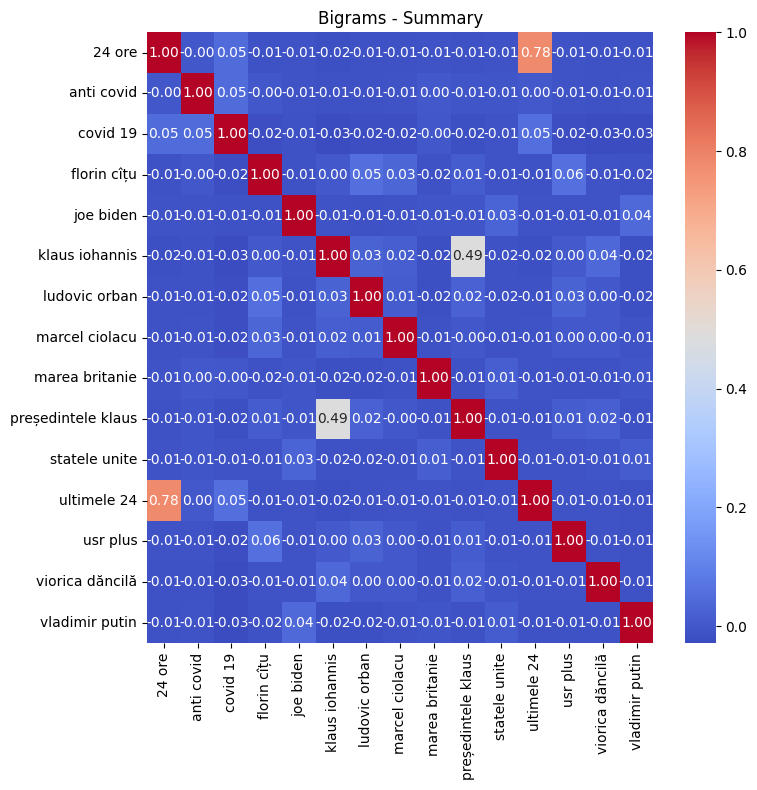

In [14]:
vectorizer = TfidfVectorizer(max_features=15, stop_words=stop_words_ro, ngram_range = (2,2))
x = vectorizer.fit_transform(train['Summary'])

# Convert to DataFrame
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())

# Plotting correlation
plot_correlation(df_tfidfvect, 'Bigrams', 'Summary', 800, 800, 12)

In [ ]:
vectorizer = TfidfVectorizer(max_features=15, stop_words=stop_words_ro, ngram_range = (3,3))
x = vectorizer.fit_transform(train['Content'])

# Convert to DataFrame
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())

# Plotting correlation
plot_correlation(df_tfidfvect, 'Trigrams', ' Content', 800, 800, 12)

In [ ]:
vectorizer = TfidfVectorizer(max_features=15, stop_words=stop_words_ro, ngram_range = (3,3))
x = vectorizer.fit_transform(train['Summary'])

# Convert to DataFrame
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())

# Plotting correlation
plot_correlation(df_tfidfvect, 'Trigrams', ' Content', 800, 800, 12)

In [27]:
# Transforming dataframes into datasets
train_ds = Dataset.from_pandas(train)
test_ds = Dataset.from_pandas(test)

print(train_ds)
print('\n' * 2)
print(test_ds)

Dataset({
    features: ['Category', 'Title', 'Content', 'Summary', 'href', 'Source'],
    num_rows: 50000
})



Dataset({
    features: ['Category', 'Title', 'Content', 'Summary', 'href', 'Source'],
    num_rows: 5000
})


In [28]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "google/mt5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

In [29]:
def tokenize_function(df):
    input_encodings = tokenizer(df["Content"].tolist(), max_length=512, truncation=True, padding="max_length", return_tensors="pt")
    target_encodings = tokenizer(df["Summary"].tolist(), max_length=128, truncation=True, padding="max_length", return_tensors="pt")
    
    input_encodings["labels"] = target_encodings["input_ids"]
    return input_encodings

train_encodings = tokenize_function(train)
test_encodings = tokenize_function(test)

In [30]:
import torch

class SummarizationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

train_dataset = SummarizationDataset(train_encodings)
test_dataset = SummarizationDataset(test_encodings)

In [33]:
from transformers import TrainingArguments,Trainer
training_args = TrainingArguments(
    output_dir="./mt5_base_finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=10e-4,
    weight_decay=0.01,
    num_train_epochs=10,
    logging_dir="./logs",
    logging_steps=500,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

In [34]:
trainer.train()
trainer.save_model('./mt5_base_finetuned_50k')

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,1.955700,1.824881
2,1.286700,1.193841
3,1.136100,1.152012
4,1.048900,1.115333
5,0.960400,1.107318
6,0.894900,1.118881
7,0.796400,1.123657
8,0.740300,1.156464
9,0.675300,1.179720
10,0.630200,1.205190


In [37]:
from evaluate import load as load_metric
rouge = load_metric('rouge') #

new_model1 = AutoModelForSeq2SeqLM.from_pretrained('./mt5_base_finetuned_50k').to(device)
# model list for evaluation
models = {
    "mt5_base_finetuned": new_model1 
}

# First 100 examples for fast evaluation
test_texts = test_ds["Content"][:100] 
test_summaries = test_ds["Summary"][:100] 


def generate_summary(model, texts):
    inputs = tokenizer(texts, max_length=512, truncation=True, padding="max_length", return_tensors="pt")
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)
    outputs = model.generate(input_ids, attention_mask=attention_mask, max_length=128)
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)


results = {}

for name, model in models.items():
    print(f"Evaluating {name}...")
    generated_summaries = generate_summary(model, test_texts)

    # Rouge score
    rouge_scores = rouge.compute(predictions=generated_summaries, references=test_summaries)

    results[name] = rouge_scores

for name, score in results.items():
    print(f"\n{name} Results:")
    for key, value in score.items():
        print(f"{key}: {value:.4f}")

Evaluating mt5_base_finetuned...

mt5_base_finetuned Results:
rouge1: 0.3771
rouge2: 0.1969
rougeL: 0.2839
rougeLsum: 0.2839


In [40]:
def generate_summary(main_news):
    source_encoding = tokenizer(
        main_news,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # Move tensors to the same device as the model
    source_encoding = {key: val.to(device) for key, val in source_encoding.items()}

    generated_ids = new_model1.generate(
        input_ids=source_encoding["input_ids"],
        attention_mask=source_encoding["attention_mask"],
        num_beams=4,
        max_length=128,
        repetition_penalty=2.0,
        length_penalty=1.5,
        early_stopping=True
    )

    preds = [
        tokenizer.decode(
            gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True
        ) 
        for gen_id in generated_ids
    ]

    return preds[0]

In [41]:
text = """Răspuns de la Washington pentru Călin Georgescu, după acuzațiile că NATO ar putea folosi baza de la Kogălniceanu pentru a ataca Rusia. 
„Cred că acest tip de propagandă a fricii chiar nu își are locul. Și ar trebui să încerce să ofere niște dovezi dacă va continua cu astfel de declarații”, a declarat marți la București secretarul adjunct american al Biroului pentru afaceri europene si eurasiatice, James O’Brien, în legătură cu declarațiile lui Georgescu.

Acuzațiile formulate de Călin Georgescu cum că baza militară de la Mihail Kogălniceanu ar putea fi folosită pentru a lansa o ofensivă împotriva Rusiei sunt „prostii”, a spus marți un înalt oficial american.
„Într-un cuvânt, prostii. Aceasta este o bază românească pentru a apăra România. România găzduiește acolo câțiva militari americani care ajută România să se apere. Cred că acest tip de propagandă a fricii chiar nu își are locul. Și ar trebui să încerce să ofere niște dovezi dacă va continua cu astfel de declarații”, a declarat James O’Brien, adjunctul secretarului de stat pentru afaceri europene si eurasiatice, într-o întâlnire cu jurnaliștii la ambasada SUA la București.

Călin Georgescu a făcut declarațiile într-un interviu acordat lui Shawn Ryan, fost soldat american, în prezent podcaster.
„Ce se întâmplă acum în România și faptul că nu avem nicio reacție din afară, în special din Statele Unite, arată că ei nu înțeleg ce se întâmplă aici, pentru că dacă folosesc România ca poartă de intrare în război… ce urmează? Nu avem nevoie de război, asta spun eu”, a spus Călin Georgescu în fragmentul difuzat de Shawn Ryan, potrivit Digi24.
În continuare, în timpul interviului, Ryan a făcut referire la baza de la Kogălniceanu. „Așadar, această bază NATO, ca să fie clar, cea mai mare bază NATO construită vreodată în Europa, va fi folosită pentru a conduce o ofensivă majoră în Rusia”, a concluzionat acesta.

Călin Georgescu nu l-a contrazis. „Exact acesta este cuvântul – ofensivă. Ceea ce este greșit. Nu putem accepta asta. Nu este războiul nostru”, a spus el."""
summary = generate_summary(text)

In [42]:
print(summary)

După acuzațiile că NATO ar putea folosi baza de la Kogălniceanu pentru a ataca Rusia, Călin Georgescu spune că acest tip de propagandă a fricii chiar nu își are locul..„Cred că acest tip de propagandă a fricii chiar nu își are locul”, a spus marți un înalt oficial american..Într-un cuvânt, prostii. Aceasta este o bază românească pentru a apăra România. România găzduiește


In [43]:
import pandas as pd

data = {
    "Model": ["t5-small-10k", "t5-small-50k", "t5-base-10k", "t5-base-50k"],
    "rouge1": [0.3402, 0.3530, 0.1632, 0.3771],
    "rouge2": [0.1610, 0.1800, 0.0067, 0.1969],
    "rougeL": [0.2504, 0.2605, 0.1222, 0.2839],
    "rougeLsum": [0.2498, 0.2605, 0.1223, 0.2839],
}

df = pd.DataFrame(data)

print(df)


          Model  rouge1  rouge2  rougeL  rougeLsum
0  t5-small-10k  0.3402  0.1610  0.2504     0.2498
1  t5-small-50k  0.3530  0.1800  0.2605     0.2605
2   t5-base-10k  0.1632  0.0067  0.1222     0.1223
3   t5-base-50k  0.3771  0.1969  0.2839     0.2839
